# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_055  P04264           19.923
Sample_089  P01814           16.536
Sample_162  O43827           17.221
Sample_093  P01860           19.774
Sample_079  Q8NI22           16.518
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups
Sample_202  P48163           13.397
Sample_008  P04430           15.479
Sample_114  Q969Z4           15.878
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.098
            A0A075B6Q5                 12.339
            A0A075B6R2                 12.502
            A0A075B6S5                 13.156
            A0A087WSY4                 13.672
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.977
            Q9UI40;Q9UI40-2            12.886
            Q9UIW2                     11.836
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.163
            Q9UP79                     12.852
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.021,15.050,16.842,19.863,15.593,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.490,19.067,...,15.528,15.576,14.220,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.548,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.661,17.705,17.039,16.074,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.598,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.211,15.345,17.084,18.708,14.249,19.433,12.124,10.955
Sample_207,15.739,16.877,15.469,16.898,14.929,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.965,13.437,12.673,12.048,13.743,13.163,12.394,13.207,12.803,13.224
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.763,19.067,16.127,...,13.453,13.660,11.628,12.020,13.260,11.343,14.244,12.015,12.129,13.717
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.386,12.583,12.147,14.089,13.090,14.741,12.102,13.188,12.598,13.183
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.607,13.305,12.806,12.749,12.962,13.630,13.517,11.392,13.642,11.961
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.570,13.366,13.328,12.676,13.151,12.790,12.791,13.454,13.028,12.660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.306,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 157.75it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 12.85it/s]

100%|██████████| 2/2 [00:00<00:00, 12.79it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  9.73it/s]

100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.45it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  9.03it/s]

 60%|██████    | 3/5 [00:00<00:00,  6.09it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.92it/s]

100%|██████████| 5/5 [00:00<00:00,  4.79it/s]

100%|██████████| 5/5 [00:00<00:00,  5.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.12it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.09it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.44it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.41it/s]

100%|██████████| 6/6 [00:01<00:00,  4.11it/s]

100%|██████████| 6/6 [00:01<00:00,  4.47it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 13.07it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.78it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.97it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.76it/s]

100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

100%|██████████| 7/7 [00:01<00:00,  4.31it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.27it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.41it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.64it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.38it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.31it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.18it/s]

100%|██████████| 8/8 [00:01<00:00,  4.24it/s]

100%|██████████| 8/8 [00:01<00:00,  4.55it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.38it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.54it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.36it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.35it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.01it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.94it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.85it/s]

100%|██████████| 9/9 [00:02<00:00,  3.65it/s]

100%|██████████| 9/9 [00:02<00:00,  4.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.74it/s]

 30%|███       | 3/10 [00:00<00:01,  5.93it/s]

 40%|████      | 4/10 [00:00<00:01,  4.76it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.73it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.05it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.16it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.25it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.99it/s]

100%|██████████| 10/10 [00:02<00:00,  2.96it/s]

100%|██████████| 10/10 [00:02<00:00,  3.44it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.19it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.32it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.38it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.07it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.96it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.07it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.35it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.51it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.27it/s]

100%|██████████| 11/11 [00:03<00:00,  3.50it/s]

100%|██████████| 11/11 [00:03<00:00,  3.46it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.35it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.09it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.08it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.86it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.40it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.13it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.79it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.79it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.66it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.81it/s]

100%|██████████| 12/12 [00:02<00:00,  3.28it/s]

100%|██████████| 12/12 [00:03<00:00,  4.00it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.32it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.65it/s]

 31%|███       | 4/13 [00:00<00:02,  4.25it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.59it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.30it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.09it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.88it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.06it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.81it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.10it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.09it/s]

100%|██████████| 13/13 [00:03<00:00,  3.35it/s]

100%|██████████| 13/13 [00:03<00:00,  3.40it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.33it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.85it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.12it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.97it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.07it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.09it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.84it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.61it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.63it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.70it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.60it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.78it/s]

100%|██████████| 14/14 [00:03<00:00,  3.85it/s]

100%|██████████| 14/14 [00:03<00:00,  3.95it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.41it/s]

 20%|██        | 3/15 [00:00<00:02,  5.98it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.11it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.89it/s]

 40%|████      | 6/15 [00:01<00:01,  4.63it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.34it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.83it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.42it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.28it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.06it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.89it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.80it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.02it/s]

100%|██████████| 15/15 [00:04<00:00,  3.23it/s]

100%|██████████| 15/15 [00:04<00:00,  3.62it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.039 0.015          0.638 0.420       0.085   
2             0.003 0.002      0.032 0.018          0.772 0.085       0.692   
3             0.004 0.001      0.036 0.007          0.771 0.085       0.698   
4             0.004 0.002      0.049 0.020          0.747 0.089       0.708   
5             0.004 0.002      0.048 0.021          0.762 0.080       0.696   
6             0.004 0.002      0.035 0.012          0.769 0.085       0.687   
7             0.004 0.002      0.036 0.013          0.781 0.089       0.719   
8             0.005 0.002      0.047 0.017          0.780 0.085       0.724   
9             0.003 0.001      0.033 0.006          0.781 0.090       0.776   
10            0.005 0.003      0.051 0.024          0.780 0.091       0.775   
11            0.005 0.002      0.045 0.018          0.789 0.086       0.784   
12            0.005 0.002      0.047 0.016          0.799 0.088       0.805   
13            0.004 0.002      0.041 0.014          0.798 0.076       0.804   
14            0.006 0.003      0.057 0.019          0.798 0.084       0.811   
15            0.005 0.002      0.046 0.014          0.796 0.085       0.808   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.143 0.124                  0.535 0.037        0.846   
2          0.110   0.722 0.074                  0.769 0.057        0.858   
3          0.101   0.727 0.068                  0.771 0.054        0.856   
4          0.094   0.722 0.066                  0.764 0.055        0.853   
5          0.096   0.723 0.068                  0.767 0.056        0.863   
6          0.103   0.719 0.069                  0.765 0.055        0.864   
7          0.115   0.742 0.077                  0.784 0.062        0.867   
8          0.106   0.746 0.075                  0.786 0.061        0.865   
9          0.103   0.773 0.072                  0.807 0.060        0.898   
10         0.104   0.773 0.075                  0.806 0.063        0.899   
11         0.104   0.782 0.071                  0.814 0.059        0.898   
12         0.099   0.798 0.073                  0.827 0.061        0.903   
13         0.098   0.798 0.070                  0.827 0.060        0.906   
14         0.098   0.801 0.071                  0.829 0.061        0.904   
15         0.099   0.798 0.071                  0.827 0.061        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.819 0.087        210.000 0.000  
2          0.058                  0.826 0.069        210.000 0.000  
3          0.058                  0.827 0.065        210.000 0.000  
4          0.055                  0.826 0.061        210.000 0.000  
5          0.056                  0.835 0.064        210.000 0.000  
6          0.056                  0.832 0.064        210.000 0.000  
7          0.055                  0.843 0.062        210.000 0.000  
8          0.055                  0.840 0.062        210.000 0.000  
9          0.050                  0.877 0.055        210.000 0.000  
10         0.051                  0.878 0.056        210.000 0.000  
11         0.052                  0.873 0.059        210.000 0.000  
12         0.052                  0.886 0.054        210.000 0.000  
13         0.052                  0.889 0.055        210.000 0.000  
14         0.054                  0.890 0.055        210.000 0.000  
15         0.053                  0.890 0.054 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 230.80it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.39it/s]

100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.20it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.55it/s]

100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.91it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.25it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.63it/s]

100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.65it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.86it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.21it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.01it/s]

100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

100%|██████████| 6/6 [00:01<00:00,  4.01it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.50it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.25it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.35it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.17it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.08it/s]

100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

100%|██████████| 7/7 [00:01<00:00,  4.27it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.93it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.33it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.59it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.48it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.53it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.35it/s]

100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

100%|██████████| 8/8 [00:02<00:00,  3.58it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.83it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.78it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.82it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.53it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.50it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.41it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.21it/s]

100%|██████████| 9/9 [00:02<00:00,  3.29it/s]

100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.79it/s]

 30%|███       | 3/10 [00:00<00:02,  3.38it/s]

 40%|████      | 4/10 [00:01<00:02,  2.97it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.08it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.37it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.58it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.77it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.69it/s]

100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.94it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.98it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.52it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.26it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.22it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  2.89it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.68it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.56it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.73it/s]

100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

100%|██████████| 11/11 [00:03<00:00,  3.15it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.06it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.02it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.65it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.42it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.64it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.84it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.80it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.79it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.82it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.75it/s]

100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.13it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.59it/s]

 31%|███       | 4/13 [00:00<00:01,  4.95it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.42it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.17it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.93it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.52it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.44it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.12it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.67it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.61it/s]

100%|██████████| 13/13 [00:03<00:00,  2.50it/s]

100%|██████████| 13/13 [00:03<00:00,  3.29it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.68it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.36it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.95it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.17it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.17it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.16it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.11it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.95it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.06it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.15it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.37it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.28it/s]

100%|██████████| 14/14 [00:04<00:00,  3.24it/s]

100%|██████████| 14/14 [00:04<00:00,  3.22it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.06it/s]

 20%|██        | 3/15 [00:00<00:03,  3.87it/s]

 27%|██▋       | 4/15 [00:01<00:02,  3.72it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.79it/s]

 40%|████      | 6/15 [00:01<00:02,  3.80it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.78it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.59it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.74it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.63it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.66it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.71it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.65it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.04it/s]

100%|██████████| 15/15 [00:04<00:00,  2.84it/s]

100%|██████████| 15/15 [00:04<00:00,  3.48it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.056 0.019          0.000 0.000       0.000   
2             0.005 0.003      0.054 0.017          0.758 0.095       0.551   
3             0.005 0.003      0.049 0.021          0.738 0.089       0.551   
4             0.005 0.003      0.053 0.024          0.785 0.103       0.561   
5             0.004 0.003      0.046 0.018          0.731 0.090       0.568   
6             0.004 0.002      0.042 0.014          0.720 0.090       0.581   
7             0.004 0.002      0.046 0.016          0.793 0.104       0.755   
8             0.004 0.001      0.039 0.011          0.786 0.101       0.757   
9             0.004 0.001      0.039 0.017          0.778 0.099       0.757   
10            0.005 0.002      0.053 0.020          0.816 0.099       0.781   
11            0.004 0.001      0.036 0.007          0.816 0.104       0.781   
12            0.005 0.002      0.046 0.019          0.819 0.109       0.773   
13            0.004 0.002      0.035 0.010          0.830 0.087       0.789   
14            0.004 0.002      0.042 0.013          0.831 0.088       0.788   
15            0.005 0.002      0.051 0.020          0.829 0.087       0.787   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.857   
2          0.109   0.632 0.092                  0.710 0.059        0.770   
3          0.110   0.624 0.088                  0.703 0.055        0.766   
4          0.117   0.647 0.095                  0.723 0.060        0.768   
5          0.114   0.631 0.082                  0.706 0.052        0.777   
6          0.105   0.636 0.075                  0.705 0.052        0.777   
7          0.107   0.767 0.081                  0.802 0.066        0.892   
8          0.101   0.765 0.077                  0.800 0.063        0.889   
9          0.105   0.761 0.076                  0.797 0.062        0.889   
10         0.104   0.791 0.072                  0.823 0.059        0.910   
11         0.113   0.790 0.077                  0.822 0.064        0.918   
12         0.120   0.788 0.087                  0.820 0.071        0.918   
13         0.109   0.803 0.073                  0.833 0.059        0.925   
14         0.112   0.802 0.074                  0.833 0.060        0.924   
15         0.109   0.801 0.073                  0.832 0.059        0.924   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.826 0.089        210.000 0.000  
2          0.067                  0.746 0.088        210.000 0.000  
3          0.066                  0.740 0.086        210.000 0.000  
4          0.070                  0.752 0.091        210.000 0.000  
5          0.065                  0.748 0.086        210.000 0.000  
6          0.063                  0.738 0.084        210.000 0.000  
7          0.051                  0.868 0.064        210.000 0.000  
8          0.055                  0.866 0.067        210.000 0.000  
9          0.054                  0.867 0.066        210.000 0.000  
10         0.047                  0.886 0.061        210.000 0.000  
11         0.045                  0.894 0.056        210.000 0.000  
12         0.045                  0.895 0.056        210.000 0.000  
13         0.042                  0.904 0.052        210.000 0.000  
14         0.041                  0.904 0.051        210.000 0.000  
15         0.040                  0.903 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 970.01it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 37.35it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 26.43it/s]

100%|██████████| 3/3 [00:00<00:00, 25.94it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.48it/s]

100%|██████████| 4/4 [00:00<00:00, 19.19it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.08it/s]

100%|██████████| 5/5 [00:00<00:00, 16.41it/s]

100%|██████████| 5/5 [00:00<00:00, 16.75it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.95it/s]

100%|██████████| 6/6 [00:00<00:00, 18.52it/s]

100%|██████████| 6/6 [00:00<00:00, 18.85it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 19.76it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 12.66it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 13.14it/s]

100%|██████████| 7/7 [00:00<00:00, 13.04it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 15.15it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 11.83it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.11it/s]

100%|██████████| 8/8 [00:00<00:00, 11.59it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 17.44it/s]

 44%|████▍     | 4/9 [00:00<00:00, 13.12it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 10.30it/s]

 89%|████████▉ | 8/9 [00:00<00:00,  8.94it/s]

100%|██████████| 9/9 [00:00<00:00,  8.93it/s]

100%|██████████| 9/9 [00:00<00:00,  9.75it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.14it/s]

 50%|█████     | 5/10 [00:00<00:00, 15.97it/s]

 70%|███████   | 7/10 [00:00<00:00, 16.02it/s]

 90%|█████████ | 9/10 [00:00<00:00, 14.78it/s]

100%|██████████| 10/10 [00:00<00:00, 14.82it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.84it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 17.39it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 16.23it/s]

 91%|█████████ | 10/11 [00:00<00:00, 12.93it/s]

100%|██████████| 11/11 [00:00<00:00, 13.96it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.91it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.25it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 16.04it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 13.99it/s]

100%|██████████| 12/12 [00:00<00:00, 14.43it/s]

100%|██████████| 12/12 [00:00<00:00, 15.01it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 15.51it/s]

 38%|███▊      | 5/13 [00:00<00:00, 11.05it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 10.34it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.79it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.09it/s]

100%|██████████| 13/13 [00:01<00:00, 11.65it/s]

100%|██████████| 13/13 [00:01<00:00, 11.37it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 16.97it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.55it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.39it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.12it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 14.22it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 11.76it/s]

100%|██████████| 14/14 [00:01<00:00, 12.39it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.60it/s]

 40%|████      | 6/15 [00:00<00:00, 19.19it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 19.19it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 17.73it/s]

 80%|████████  | 12/15 [00:00<00:00, 16.03it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.50it/s]

100%|██████████| 15/15 [00:00<00:00, 16.63it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.029 0.007          0.000 0.000       0.000   
2             0.004 0.002      0.044 0.016          0.653 0.115       0.464   
3             0.004 0.002      0.038 0.013          0.640 0.114       0.458   
4             0.005 0.002      0.049 0.020          0.665 0.117       0.478   
5             0.004 0.002      0.046 0.018          0.668 0.112       0.498   
6             0.004 0.002      0.042 0.016          0.668 0.113       0.489   
7             0.006 0.003      0.064 0.025          0.676 0.113       0.487   
8             0.004 0.001      0.038 0.007          0.686 0.097       0.586   
9             0.006 0.003      0.066 0.029          0.680 0.107       0.571   
10            0.004 0.002      0.044 0.016          0.670 0.105       0.576   
11            0.006 0.002      0.065 0.020          0.684 0.100       0.602   
12            0.004 0.001      0.040 0.010          0.680 0.099       0.604   
13            0.005 0.003      0.055 0.020          0.668 0.101       0.613   
14            0.006 0.003      0.056 0.024          0.664 0.097       0.612   
15            0.005 0.002      0.052 0.023          0.656 0.099       0.607   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.734   
2          0.099   0.536 0.088                  0.639 0.061        0.729   
3          0.093   0.529 0.086                  0.633 0.061        0.721   
4          0.115   0.547 0.095                  0.647 0.062        0.742   
5          0.123   0.562 0.104                  0.656 0.069        0.729   
6          0.124   0.554 0.103                  0.652 0.068        0.728   
7          0.127   0.555 0.103                  0.654 0.067        0.723   
8          0.119   0.622 0.087                  0.691 0.061        0.749   
9          0.113   0.613 0.090                  0.683 0.066        0.743   
10         0.122   0.611 0.097                  0.681 0.068        0.752   
11         0.114   0.633 0.085                  0.696 0.065        0.758   
12         0.113   0.632 0.085                  0.695 0.065        0.755   
13         0.117   0.633 0.089                  0.693 0.069        0.769   
14         0.115   0.630 0.087                  0.690 0.067        0.766   
15         0.117   0.624 0.090                  0.685 0.070        0.763   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.683 0.087        210.000 0.000  
2          0.074                  0.656 0.095        210.000 0.000  
3          0.075                  0.646 0.094        210.000 0.000  
4          0.075                  0.673 0.093        210.000 0.000  
5          0.080                  0.672 0.096        210.000 0.000  
6          0.079                  0.672 0.096        210.000 0.000  
7          0.082                  0.668 0.097        210.000 0.000  
8          0.075                  0.718 0.084        210.000 0.000  
9          0.077                  0.712 0.084        210.000 0.000  
10         0.079                  0.721 0.086        210.000 0.000  
11         0.081                  0.720 0.094        210.000 0.000  
12         0.082                  0.714 0.093        210.000 0.000  
13         0.080                  0.730 0.087        210.000 0.000  
14         0.080                  0.726 0.087        210.000 0.000  
15         0.080                  0.724 0.086 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,10,9
score_time,14,1,9
test_precision,12,14,8
test_recall,14,13,13
test_f1,14,13,11
test_balanced_accuracy,14,13,11
test_roc_auc,13,13,13
test_average_precision,14,13,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.02it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.27it/s]

 31%|███       | 4/13 [00:00<00:01,  4.52it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.06it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.42it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.64it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.53it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.57it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.71it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.98it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.10it/s]

100%|██████████| 13/13 [00:04<00:00,  3.00it/s]

100%|██████████| 13/13 [00:04<00:00,  3.17it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.24it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.98it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 14.02it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 15.03it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 15.37it/s]

100%|██████████| 13/13 [00:00<00:00, 14.69it/s]

100%|██████████| 13/13 [00:00<00:00, 14.95it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.29it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.70it/s]

 31%|███       | 4/13 [00:00<00:01,  5.08it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.70it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.38it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.60it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.95it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.71it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.82it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.07it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.23it/s]

100%|██████████| 13/13 [00:03<00:00,  3.34it/s]

100%|██████████| 13/13 [00:03<00:00,  3.55it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


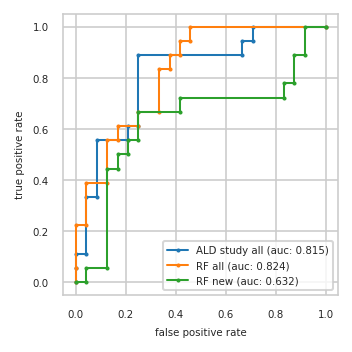

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.111  0.000 0.222  0.042 0.056
3          0.042 0.111  0.042 0.222  0.125 0.056
4          0.042 0.333  0.042 0.389  0.125 0.444
5          0.083 0.333  0.125 0.389  0.167 0.444
6          0.083 0.556  0.125 0.556  0.167 0.500
7          0.208 0.556  0.167 0.556  0.208 0.500
8          0.208 0.611  0.167 0.611  0.208 0.556
9          0.250 0.611  0.250 0.611  0.250 0.556
10         0.250 0.889  0.250 0.667  0.250 0.667
11         0.667 0.889  0.333 0.667  0.417 0.667
12         0.667 0.944  0.333 0.833  0.417 0.722
13         0.708 0.944  0.375 0.833  0.833 0.722
14         0.708 1.000  0.375 0.889  0.833 0.778
15         1.000 1.000  0.417 0.889  0.875 0.778
16           NaN   NaN  0.417 0.944  0.875 0.889
17           NaN   NaN  0.458 0.944  0.917 0.889
18           NaN   NaN  0.458 1.000  0.917 1.000
19           NaN   NaN  1.000 1.000  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,Q9NX62,Q9HAT2,E7EPV7;P37840;P37840-2
2,P04114,P25189;P25189-2,E5RK69;E7EMC6;P08133;P08133-2
3,P61981,P10636-2;P10636-6,P31321
4,P14174,P14174,Q9NUQ9
5,P04075,P61981,Q96GD0
6,Q9Y2T3;Q9Y2T3-3,P04075,J3KSJ8;Q9UD71;Q9UD71-2
7,P63104,Q14894,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,C9JF17;P05090,P63104,H0Y7T8;P49418;P49418-2


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


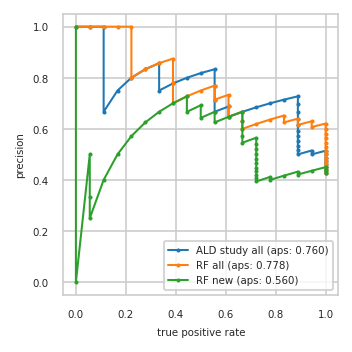

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.421 0.889
5          0.486 1.000     0.486 1.000     0.432 0.889
6          0.500 1.000     0.500 1.000     0.417 0.833
7          0.514 1.000     0.514 1.000     0.400 0.778
8          0.500 0.944     0.529 1.000     0.412 0.778
9          0.515 0.944     0.545 1.000     0.394 0.722
10         0.500 0.889     0.562 1.000     0.406 0.722
11         0.516 0.889     0.581 1.000     0.419 0.722
12         0.533 0.889     0.600 1.000     0.433 0.722
13         0.552 0.889     0.621 1.000     0.448 0.722
14         0.571 0.889     0.607 0.944     0.464 0.722
15         0.593 0.889     0.630 0.944     0.481 0.722
16         0.615 0.889     0.615 0.889     0.500 0.722
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.727 0.889     0.636 0.778     0.545 0.667
21         0.714 0.833     0.619 0.722     0.571 0.667
22         0.700 0.778     0.600 0.667     0.600 0.667
23         0.684 0.722     0.632 0.667     0.632 0.667
24         0.667 0.667     0.667 0.667     0.667 0.667
25         0.647 0.611     0.647 0.611     0.647 0.611
26         0.688 0.611     0.688 0.611     0.625 0.556
27         0.667 0.556     0.733 0.611     0.667 0.556
28         0.714 0.556     0.714 0.556     0.643 0.500
29         0.769 0.556     0.769 0.556     0.692 0.500
30         0.833 0.556     0.750 0.500     0.667 0.444
31         0.818 0.500     0.727 0.444     0.727 0.444
32         0.800 0.444     0.700 0.389     0.700 0.389
33         0.778 0.389     0.778 0.389     0.667 0.333
34         0.750 0.333     0.875 0.389     0.625 0.278
35         0.857 0.333     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.500 0.167
37         0.800 0.222     0.800 0.222     0.400 0.111
38         0.750 0.167     1.000 0.222     0.250 0.056
39         0.667 0.111     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


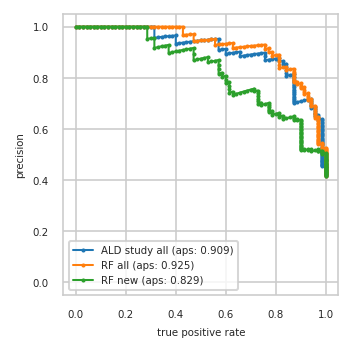

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


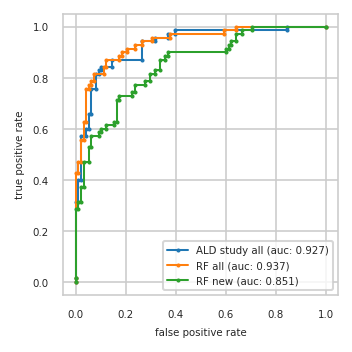

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}